Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 4.2) 강남역 맛집 리뷰로 알아보는 감성 분류

### 바로가기

- [<Step1. 크롤링> : 카카오맵 리뷰 크롤링](#<Step1.-크롤링>-:-카카오맵-리뷰-크롤링)
    - [카카오맵 크롤링]
    - [맛집 리뷰 정보 크롤링]
- [<Step2. 전처리> : TF-IDF를 이용한 핵심어 추출](#<Step2.-전처리>-:-TF\-IDF를-이용한-핵심어-추출)
    - [형태소 추출하기]
    - [분류 모델의 학습 데이터로 변환하기]
- [<Step3. 분류> : 긍정 부정 리뷰 분류하기](#<Step3.-분류>-:-긍정-부정-리뷰-분류하기)
    - [분류 모델링]
    - [분류 모델 개선]
- [<Step4. 활용> : 중요 키워드 분석](#<Step4.-활용>-:-중요-키워드-분석)
    - [회귀 모델의 피처 영향력 추출]
    - [중요 피처의 형태소]

-----

In [3]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 카카오맵 리뷰 크롤링 

### [카카오맵 개발자도구 화면]

![앱 생성 페이지](img/1.png)

-----

In [6]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time

# brew 로 설치된 chromedriver의 path (Mac)
path = '/usr/local/bin/chromedriver'

# 윈도우용 크롬 웹드라이버 실행 경로 (Windows)
excutable_path = 'chromedriver.exe'

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://map.kakao.com/"

# 크롬 드라이버를 사용합니다 (맥은 첫 줄, 윈도우는 두번째 줄 실행)
# driver = webdriver.Chrome(path)
driver = webdriver.Chrome(executable_path=excutable_path)

# 카카오 지도에 접속합니다
driver.get(source_url)

# 검색창에 검색어를 입력합니다
searchbox = driver.find_element_by_xpath("//input[@id='search.keyword.query']")
searchbox.send_keys("강남역 고기집")

# 검색버튼을 눌러서 결과를 가져옵니다
searchbutton = driver.find_element_by_xpath("//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)

# 검색 결과를 가져올 시간을 기다립니다
time.sleep(2)

# 검색 결과의 페이지 소스를 가져옵니다
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보를 파싱합니다
soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저를 종료합니다.
driver.close()

https://place.map.kakao.com/85570955
https://place.map.kakao.com/1503746075
https://place.map.kakao.com/95713992
https://place.map.kakao.com/741391811
https://place.map.kakao.com/2011092566
https://place.map.kakao.com/2062959414
https://place.map.kakao.com/1648266796
https://place.map.kakao.com/168079537
https://place.map.kakao.com/13573220
https://place.map.kakao.com/263830255
https://place.map.kakao.com/1780387311
https://place.map.kakao.com/27238067
https://place.map.kakao.com/26431943
https://place.map.kakao.com/1907052666
https://place.map.kakao.com/2021432189
https://place.map.kakao.com/1052874675


-----

### [맛집 리뷰 정보 크롤링]

![앱 생성 페이지](img/2.png)

-----

In [7]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# driver = webdriver.Chrome(path)  # for Mac
driver = webdriver.Chrome(executable_path=excutable_path)  # for Windows
for page_url in page_urls:
    
    # 상세보기 페이지에 접속합니다
    driver.get(page_url)
    time.sleep(2)
    
    # 첫 페이지 리뷰를 크롤링합니다
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
    
    # 별점을 가져옵니다.
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
    
    # 리뷰를 가져옵니다.
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # 2-5페이지의 리뷰를 크롤링합니다
    for button_num in range(2, 6):
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행하지 않습니다.
        try:
            another_reviews = driver.find_element_by_xpath("//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            # 페이지 리뷰를 크롤링합니다
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})

            # 별점을 가져옵니다.
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

            # 리뷰를 가져옵니다.
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [8]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()

(372, 3)


,score,review,y
0,5,新鮮でおいしいです。,1
1,4,녹는다 녹아,1
2,4,,1
3,5,흠잡을곳 없는 반찬이 정갈합니다,1
4,5,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...,1


In [7]:
df.to_csv("review_data.csv", index=False)

-----

# <Step2. 전처리> : TF-IDF를 이용한 핵심어 추출

### [형태소 추출하기]

##### 한글 텍스트로 전처리

In [120]:
df = pd.read_csv("review_data.csv")

In [121]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [122]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df = pd.read_csv("review_data.csv")
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출합니다
df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
1,4,1,녹는다 녹아
2,4,1,좋아요
3,5,1,흠잡을곳 없는 반찬이 정갈합니다
4,5,1,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...
5,5,1,살치살 미쳤네요 대박입니다 퀄리티 굳이에요


-----

##### 형태소 단위로 추출

In [123]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'].values[0])
print(result)

['녹는다/Verb', '녹아/Verb']


-----

### [분류 모델의 학습 데이터로 변환하기]

##### corpus index 생성하기

In [124]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [125]:
X.shape

(370, 2355)

In [126]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'녹는다/Verb': 443, '녹아/Verb': 444, '좋아요/Adjective': 1900, '흠잡을/Adjective': 2346, '곳/Noun': 191, '없는/A..


In [127]:
print(df['ko_text'].values[0])
print(X[0])

녹는다 녹아
  (0, 443)	1
  (0, 444)	1


-----

##### TF-IDF로 변환

In [128]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [129]:
print(X.shape)
print(X[0])

(370, 2355)
  (0, 444)	0.7071067811865475
  (0, 443)	0.7071067811865475


-----

# <Step3. 분류> : 긍정 부정 리뷰 분류하기

### [분류 모델링]

##### 데이터셋 분리

In [130]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(259, 2355)
(111, 2355)


-----

##### Logistic Regression

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision : 0.810
Recall : 0.919
F1 : 0.861


In [132]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[21 16]
 [ 6 68]]


AUC : 0.898


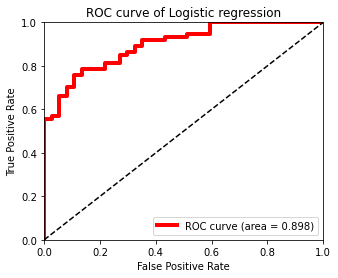

In [133]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

------

# <Step4. 활용> : 중요 키워드 분석

### [회귀 모델의 피처 영향력 추출]

<BarContainer object of 2355 artists>

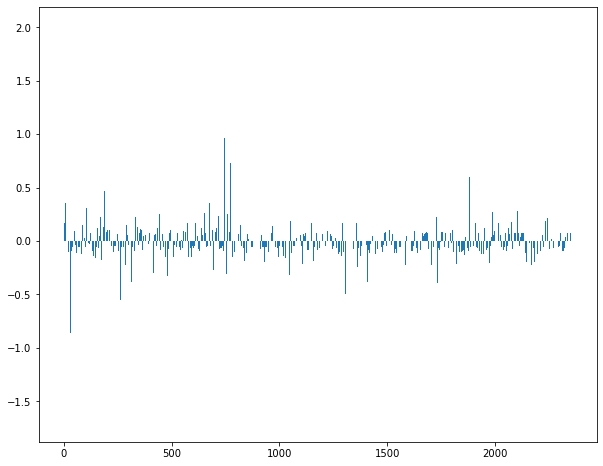

In [134]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [135]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(2.005692293233956, 2042), (1.6692476943563863, 1900), (1.0870064528652426, 763), (0.9657684076470117, 745), (0.7276255745083494, 773)]
[(-0.8605696458490166, 30), (-1.0702632912456227, 1351), (-1.1062925997579705, 1691), (-1.1697704691135293, 1011), (-1.6940893569402118, 987)]


-----

### [중요 피처의 형태소]

In [136]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [137]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')

{443: '녹는다/Verb', 444: '녹아/Verb', 1900: '좋아요/Adjective', 2346: '흠잡을/Adjective', 191: '곳/Noun', 1483:..


In [138]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최고/Noun 2.005692293233956
좋아요/Adjective 1.6692476943563863
맛있어요/Adjective 1.0870064528652426
맛있고/Adjective 0.9657684076470117
맛있음/Adjective 0.7276255745083494
존맛/Noun 0.6023446715957659
도/Josa 0.5745643498123096
좋은/Adjective 0.5151186773211861
강남/Noun 0.4956664193460228
깔끔하고/Adjective 0.4740556266941344
곱/Noun 0.4681650757238441
맛있게/Adjective 0.461363298132383
맛있네요/Adjective 0.4593403243374981
친절하고/Adjective 0.45633479961768425
다/Adverb 0.4440837877743556
음식/Noun 0.43496099861299975
추천/Noun 0.3892574644699166
곳/Noun 0.3854982871631295
육즙/Noun 0.37025678991594896
있으나/Adjective 0.3686146498936071


In [139]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

있음/Adjective -0.43291552766368696
사람/Noun -0.44493976293906584
없고/Adjective -0.4570938334421588
마세요/Verb -0.47855300723936955
는/Josa -0.48923838383783846
쏘/Verb -0.4958454785052458
에/Josa -0.5092980004379798
대비/Noun -0.5197166023805634
주문/Noun -0.5200749800192043
좀/Noun -0.54504070834056
그냥/Noun -0.5501594822686582
불친절/Noun -0.5588501376333425
조금/Noun -0.5720363867912582
을/Josa -0.6410157429350765
은/Josa -0.7804399805867315
가/Josa -0.8605696458490166
아쉬워요/Adjective -1.0702632912456227
이에요/Josa -1.1062925997579705
보통/Noun -1.1697704691135293
별로/Noun -1.6940893569402118


-----

### `[미니 퀴즈 - 4.3]`
- `피처 영향력에 따라 정렬된 형태소에서, 품사별 긍정 형태소 10개와 부정 형태소 10개를 탐색해 보세요.` 
    - “/”로 구분되어있는 정보를 활용하여 품사별 형태소를 추출할 수 있습니다.

In [140]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [141]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('최고/Noun', 2.005692293233956),
 ('존맛/Noun', 0.6023446715957659),
 ('강남/Noun', 0.4956664193460228),
 ('곱/Noun', 0.4681650757238441),
 ('음식/Noun', 0.43496099861299975),
 ('추천/Noun', 0.3892574644699166),
 ('곳/Noun', 0.3854982871631295),
 ('육즙/Noun', 0.37025678991594896),
 ('맛있댜/Noun', 0.35279620545500545),
 ('맛맛/Noun', 0.35279620545500545)]

In [142]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('좋아요/Adjective', 1.6692476943563863),
 ('맛있어요/Adjective', 1.0870064528652426),
 ('맛있고/Adjective', 0.9657684076470117),
 ('맛있음/Adjective', 0.7276255745083494),
 ('좋은/Adjective', 0.5151186773211861),
 ('깔끔하고/Adjective', 0.4740556266941344),
 ('맛있게/Adjective', 0.461363298132383),
 ('맛있네요/Adjective', 0.4593403243374981),
 ('친절하고/Adjective', 0.45633479961768425),
 ('있으나/Adjective', 0.3686146498936071)]